# Tune the algorithms designed for stationary environments

In this notebook I tune the hyper parameters of those algorithms that were designed to work in stationary environments. These include: Epsilon-greedy, UCB1, LinUCB and SimOOS

For this I run them on the first 4000 points of the dataset without introducing non-stationarity.
In later experiments i will use the tuned parameters for these algorithms.

Here I use contexts of size 4.

In [1]:
import os
os.chdir("../..")
os.getcwd()

'/Users/sbokupripeku/git/work/examples/costly_nonstationary_bandits'

In [2]:
%load_ext autoreload
%autoreload 2

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import time

import algorithms
from src import evaluation
from src import costs
from src.plotting.costs import plot_costs

In [3]:
np.random.seed(42)

In [4]:
csv_file = 'experiments/nursery/nursery.csv'

In [5]:
df = pd.read_csv(csv_file)

In [6]:
df

,parents,has_nurs,form,children,housing,finance,social,health,final evaluation
0,usual,proper,complete,1,convenient,convenient,nonprob,recommended,recommend
1,usual,proper,complete,1,convenient,convenient,nonprob,priority,priority
2,usual,proper,complete,1,convenient,convenient,nonprob,not_recom,not_recom
3,usual,proper,complete,1,convenient,convenient,slightly_prob,recommended,recommend
4,usual,proper,complete,1,convenient,convenient,slightly_prob,priority,priority
...,...,...,...,...,...,...,...,...,...
12955,great_pret,very_crit,foster,more,critical,inconv,slightly_prob,priority,spec_prior
12956,great_pret,very_crit,foster,more,critical,inconv,slightly_prob,not_recom,not_recom
12957,great_pret,very_crit,foster,more,critical,inconv,problematic,recommended,spec_prior
12958,great_pret,very_crit,foster,more,critical,inconv,problematic,priority,spec_prior


### Shuffle the data

In [7]:
df = df.sample(frac=1).reset_index(drop=True)

In [8]:
df

,parents,has_nurs,form,children,housing,finance,social,health,final evaluation
0,pretentious,improper,completed,3,less_conv,inconv,problematic,not_recom,not_recom
1,pretentious,improper,completed,1,critical,convenient,nonprob,priority,spec_prior
2,usual,proper,completed,2,less_conv,inconv,problematic,priority,priority
3,great_pret,very_crit,completed,more,critical,inconv,nonprob,priority,spec_prior
4,usual,improper,foster,1,critical,convenient,slightly_prob,not_recom,not_recom
...,...,...,...,...,...,...,...,...,...
12955,great_pret,critical,foster,2,less_conv,inconv,slightly_prob,recommended,spec_prior
12956,pretentious,less_proper,complete,1,convenient,convenient,problematic,priority,priority
12957,pretentious,less_proper,complete,more,critical,convenient,problematic,not_recom,not_recom
12958,usual,proper,foster,more,critical,inconv,slightly_prob,not_recom,not_recom


In [9]:
df_num = df.astype('category')

In [10]:
df_num['final evaluation']

0         not_recom
1        spec_prior
2          priority
3        spec_prior
4         not_recom
            ...    
12955    spec_prior
12956      priority
12957     not_recom
12958     not_recom
12959    spec_prior
Name: final evaluation, Length: 12960, dtype: category
Categories (5, object): ['not_recom', 'priority', 'recommend', 'spec_prior', 'very_recom']

In [11]:
# Order categories correctly, because order has meaning.
df_num.parents = df_num.parents.cat.reorder_categories(['usual', 'pretentious', 'great_pret'])
df_num.has_nurs = df_num.has_nurs.cat.reorder_categories(
    ['proper', 'less_proper',  'improper', 'critical', 'very_crit']
)
df_num.form = df_num.form.cat.reorder_categories(['complete', 'completed', 'incomplete', 'foster'])
df_num.children = df_num.children.cat.reorder_categories(['1', '2', '3', 'more'])
df_num.housing = df_num.housing.cat.reorder_categories(['convenient', 'less_conv', 'critical'])
df_num.finance = df_num.finance.cat.reorder_categories(['convenient', 'inconv'])
df_num.social = df_num.social.cat.reorder_categories(['nonprob', 'slightly_prob', 'problematic'])
df_num.health = df_num.health.cat.reorder_categories(['not_recom', 'recommended', 'priority'])
df_num['final evaluation'] = df_num['final evaluation'].cat.reorder_categories(
    ['not_recom', 'recommend',  'very_recom', 'priority', 'spec_prior',]
)


In [12]:
df_num

,parents,has_nurs,form,children,housing,finance,social,health,final evaluation
0,pretentious,improper,completed,3,less_conv,inconv,problematic,not_recom,not_recom
1,pretentious,improper,completed,1,critical,convenient,nonprob,priority,spec_prior
2,usual,proper,completed,2,less_conv,inconv,problematic,priority,priority
3,great_pret,very_crit,completed,more,critical,inconv,nonprob,priority,spec_prior
4,usual,improper,foster,1,critical,convenient,slightly_prob,not_recom,not_recom
...,...,...,...,...,...,...,...,...,...
12955,great_pret,critical,foster,2,less_conv,inconv,slightly_prob,recommended,spec_prior
12956,pretentious,less_proper,complete,1,convenient,convenient,problematic,priority,priority
12957,pretentious,less_proper,complete,more,critical,convenient,problematic,not_recom,not_recom
12958,usual,proper,foster,more,critical,inconv,slightly_prob,not_recom,not_recom


In [13]:
for colname in df:
    df_num[colname] = df_num[colname].cat.codes + 1

In [14]:
df_num

,parents,has_nurs,form,children,housing,finance,social,health,final evaluation
0,2,3,2,3,2,2,3,1,1
1,2,3,2,1,3,1,1,3,5
2,1,1,2,2,2,2,3,3,4
3,3,5,2,4,3,2,1,3,5
4,1,3,4,1,3,1,2,1,1
...,...,...,...,...,...,...,...,...,...
12955,3,4,4,2,2,2,2,2,5
12956,2,2,1,1,1,1,3,3,4
12957,2,2,1,4,3,1,3,1,1
12958,1,1,4,4,3,2,2,1,1


In [15]:
# Features are dropped according to their usefulness for the linear regression model.
# final evaluation is target variable

all_contexts = df_num.drop(['parents', 'has_nurs', 'social', 'social', 'final evaluation'], axis=1)

# For debug and testing drop some more columns
all_contexts = all_contexts.drop(['form'], axis=1).to_numpy()
# all_contexts = all_contexts.drop(['finance', 'form'], axis=1).to_numpy()

In [16]:
all_contexts.shape

(12960, 4)

In [17]:
all_contexts

array([[3, 2, 2, 1],
       [1, 3, 1, 3],
       [2, 2, 2, 3],
       ...,
       [4, 3, 1, 1],
       [4, 3, 2, 1],
       [3, 2, 2, 3]], dtype=int8)

In [18]:
y = df_num['final evaluation']

In [19]:
y.value_counts()

1    4320
4    4266
5    4044
3     328
2       2
Name: final evaluation, dtype: int64

In [20]:
# Drop arms with small rewards

In [21]:
# Values meaning:
# not recommended (1)
# recommend (2)
# very recommend (3)
# priority acceptance (4)
# special priority (5)

In [22]:
y[y == 2] = 4

In [23]:
y[y == 3] = 4

In [24]:
y.value_counts()

4    4596
1    4320
5    4044
Name: final evaluation, dtype: int64

In [25]:
np.sum(np.where(y == 3, 1, 0))

0

In [26]:
unique = np.unique(y)
all_rewards = np.zeros((y.shape[0], len(unique)))
for n_arm, y_value in enumerate(unique):
    all_rewards[:, n_arm] = np.where(y == y_value, 1, 0)
    

In [27]:
all_rewards

array([[1., 0., 0.],
       [0., 0., 1.],
       [0., 1., 0.],
       ...,
       [1., 0., 0.],
       [1., 0., 0.],
       [0., 0., 1.]])

In [28]:
np.array(np.sum(all_rewards, axis=0), dtype=int)

array([4320, 4596, 4044])

### Find which features are useful

It might be useful to move this to another notebook later for better organization.

In [29]:
from sklearn.linear_model import LinearRegression, LogisticRegression


coefs = np.zeros((all_rewards.shape[1], all_contexts.shape[1]))
for n_arm in range(all_rewards.shape[1]):
    print(n_arm)
    model = LogisticRegression()
    model.fit(all_contexts, all_rewards[:, n_arm])
    print(model.coef_)
    coefs[n_arm, :] = model.coef_


0
[[ 5.95789122e-07 -1.09000282e-07  2.93197485e-07 -1.18003215e+01]]
1
[[-0.18603078 -0.33239928 -0.26522023  1.05266489]]
2
[[0.23537151 0.42056171 0.33544766 1.71326315]]


In [30]:
np.mean(coefs, axis= 0)

array([ 0.01644711,  0.02938744,  0.02340924, -3.01146448])

## Algorithm evaluation

In [31]:
BETA = 1

In [32]:
def plot_gains(gain_dict, change_points=()):
    fig, ax = plt.subplots(1,1, figsize=(11, 6));
        
    max_vline=0
    
    ind_to_params = {
        # ind: (mark, color)
        0: ('x', 'k'),
        1: ('o','g'),
        2: ('s','r'),
        3: ('^','blue'),
        4: ('d','olive'),
        5: ('>', 'm'),
        6: ('*', 'c'),
        7: ('<', 'y'),
    }
    
    sorted_gain_dict = {
        k:v for k,v in sorted(gain_dict.items(), key=lambda x: x[1][-1], reverse=True)
    }
    
    for ind, (label, gain) in enumerate(sorted_gain_dict.items()):
        
        mark, color = ind_to_params[ind]
        ax.plot(gain, label=label, linestyle=':', marker=mark, markevery=750, fillstyle='none', color=color)
        max_vline=max(max_vline, max(gain))
    
    extraticks = [1, 3000, 4000, 5000, 6000, 7000, 8000, 9000, 11000, 12960]
    plt.xticks(list(plt.xticks()[0][2:-1]) + extraticks, rotation=35, fontsize=16)
    plt.yticks(fontsize=16)
    
    ax.set_xlabel('Time step', fontsize=20)
    ax.set_ylabel('Cumulative gain', fontsize=20)
    


    plt.legend(prop={'size': 16});
    plt.show();

In [33]:
new_rewards = np.copy(all_rewards)
new_contexts = np.copy(all_contexts)

mean_rewards = np.ones(new_rewards.shape)*np.mean(new_rewards, axis=0)

n_arms = all_rewards.shape[1]



In [34]:
new_contexts.shape, new_rewards.shape

((12960, 4), (12960, 3))

### Stationary costs

In [35]:
cost_change_points = []
interval_count = len(cost_change_points) + 1

In [36]:
# Mean of gaussian distribution random in interval [0, 0.02] 
interval_means = [np.random.uniform(0.01, 0.03, size=(new_contexts.shape[1],)) for i in range(interval_count)]

In [37]:
interval_means

[array([0.02121625, 0.01456818, 0.02644422, 0.01591205])]

In [38]:
# Fixed std
interval_stds = [[0.001]*new_contexts.shape[1]]*interval_count

In [39]:
def get_costs():
    return costs.NonstationaryGaussianCosts(
        feature_vector_size=new_contexts.shape[1],
        change_points=cost_change_points,
        interval_means=interval_means,
        interval_stds=interval_stds,
        random_seed=42,
    )
    

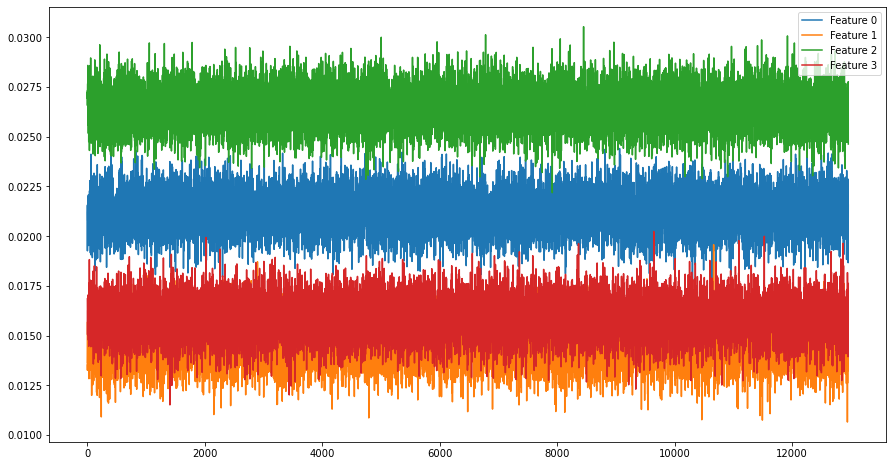

In [40]:
plot_costs(get_costs(), new_contexts.shape[0])

In [41]:
costs_obj = get_costs()

In [42]:
costs_vector = []
for t in range(new_contexts.shape[0]):
    costs_at_t = np.array(costs_obj.get_separate_costs(trial=t))
    costs_vector.append(costs_at_t)

costs_vector = np.stack(costs_vector)

In [43]:
costs_vector.shape

(12960, 4)

## Plot expected reward

Min expected reward for arm 1: 0.3333333333333333
Min expected reward for arm 2: 0.35462962962962963
Min expected reward for arm 3: 0.31203703703703706


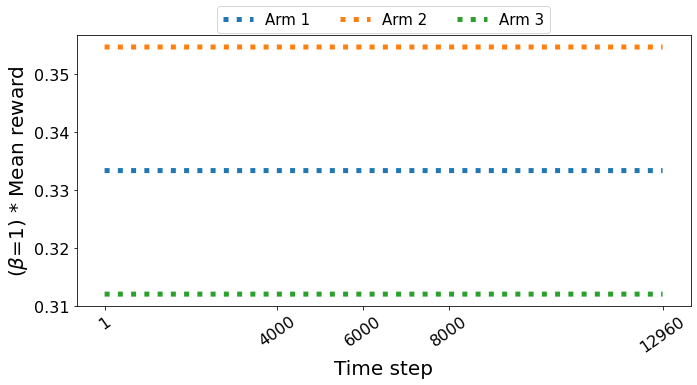

In [44]:
fig, ax = plt.subplots(1,1, figsize=(11,5))
for arm in range(n_arms):
    sum_of_costs = np.sum(costs_vector, axis=1)
    expected_gain = BETA * mean_rewards[:, arm] 
    ax.plot(expected_gain, label=f"Arm {arm+1}", linestyle=':', linewidth=5)
    print(f"Min expected reward for arm {arm+1}: {min(expected_gain)}")

    
extraticks = [1, 4000, 6000, 8000, 12960]
plt.xticks(extraticks, rotation=35, fontsize=16)

plt.yticks(fontsize=16)

ax.set_xlabel('Time step', fontsize=20)
ax.set_ylabel(fr"($\beta$={BETA}) * Mean reward", fontsize=20)

lgd = ax.legend(loc=9, ncol=5, bbox_to_anchor=(0.5, 1.132), prop={'size': 15})
plt.savefig('mean_rewards.pdf', dpi=300, bbox_extra_artists=(lgd,), bbox_inches='tight')


plt.show()


## Plot expected reward minus sum of costs

Min expected gain for arm 1: 0.24622267235062453
Min expected gain for arm 2: 0.2675189686469208
Min expected gain for arm 3: 0.22492637605432828


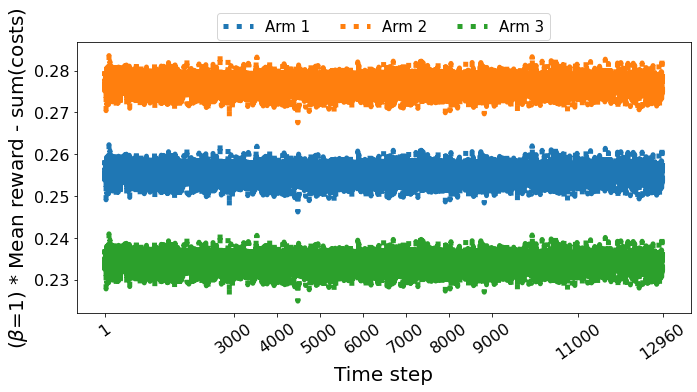

In [45]:
fig, ax = plt.subplots(1,1, figsize=(11,5))
for arm in range(n_arms):
    sum_of_costs = np.sum(costs_vector, axis=1)
    expected_gain = BETA * mean_rewards[:, arm] - sum_of_costs
    ax.plot(expected_gain, label=f"Arm {arm+1}", linestyle=':', linewidth=5)
    print(f"Min expected gain for arm {arm+1}: {min(expected_gain)}")

    
extraticks = [1, 3000, 4000, 5000, 6000, 7000, 8000, 9000, 11000, 12960]
plt.xticks(extraticks, rotation=35, fontsize=16)

plt.yticks(fontsize=16)

ax.set_xlabel('Time step', fontsize=20)
ax.set_ylabel(fr"($\beta$={BETA}) * Mean reward - sum(costs)", fontsize=20)

lgd = ax.legend(loc=9, ncol=5, bbox_to_anchor=(0.5, 1.132), prop={'size': 15})
plt.savefig('mean_rewards.pdf', dpi=300, bbox_extra_artists=(lgd,), bbox_inches='tight')


plt.show()


## Testing on non-stationary data

In [46]:
np.random.seed(42)

In [47]:
TUNING_NUM_OF_TRIALS = 5000
NUM_OF_TRIALS = all_contexts.shape[0]
NUM_REPETITIONS = 5

## Epsilon-greedy

In [48]:
egreedy_gains = {}

for eps in [0.001, 0.003, 0.005, 0.008, 0.01, 0.03, 0.05, 0.08, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7]:
    gains = np.zeros((NUM_REPETITIONS, TUNING_NUM_OF_TRIALS))
    for i in range(NUM_REPETITIONS):
        egreedy = algorithms.EpsilonGreedy(epsilon=eps, n_arms=new_rewards.shape[1])

        gain_egreedy = evaluation.evaluate_on_synthetic_data(
            egreedy,
            new_contexts,
            new_rewards,
            costs_vector,
            beta=BETA,
            stop_after=TUNING_NUM_OF_TRIALS,
        )
        gains[i, :] = gain_egreedy

    gain_egreedy = np.mean(gains, axis=0)
    egreedy_gains[eps] = gain_egreedy

E-greedy(epsilon=0.001)
Beta = 1
Total gain: 1719.0
	Total reward: 1719.0
	Total cost: 0
Execution time: 0.0s
E-greedy(epsilon=0.001)
Beta = 1
Total gain: 1683.0
	Total reward: 1683.0
	Total cost: 0
Execution time: 0.0s
E-greedy(epsilon=0.001)
Beta = 1
Total gain: 1720.0
	Total reward: 1720.0
	Total cost: 0
Execution time: 0.0s
E-greedy(epsilon=0.001)
Beta = 1
Total gain: 1717.0
	Total reward: 1717.0
	Total cost: 0
Execution time: 0.0s
E-greedy(epsilon=0.001)
Beta = 1
Total gain: 1718.0
	Total reward: 1718.0
	Total cost: 0
Execution time: 0.0s
E-greedy(epsilon=0.003)
Beta = 1
Total gain: 1707.0
	Total reward: 1707.0
	Total cost: 0
Execution time: 0.0s
E-greedy(epsilon=0.003)
Beta = 1
Total gain: 1718.0
	Total reward: 1718.0
	Total cost: 0
Execution time: 0.0s
E-greedy(epsilon=0.003)
Beta = 1
Total gain: 1717.0
	Total reward: 1717.0
	Total cost: 0
Execution time: 0.0s
E-greedy(epsilon=0.003)
Beta = 1
Total gain: 1715.0
	Total reward: 1715.0
	Total cost: 0
Execution time: 0.0s
E-greedy(e

In [49]:
last_gains = {k:v[-1] for k,v in egreedy_gains.items()}
best_eps = sorted(last_gains.items(), key=lambda x: x[1])[-1][0];
best_eps

0.05

In [50]:
gains = np.zeros((NUM_REPETITIONS, NUM_OF_TRIALS))
for i in range(NUM_REPETITIONS):
    egreedy = algorithms.EpsilonGreedy(epsilon=best_eps, n_arms=new_rewards.shape[1])

    gain_egreedy = evaluation.evaluate_on_synthetic_data(
        egreedy,
        new_contexts,
        new_rewards,
        costs_vector,
        beta=BETA,
        stop_after=NUM_OF_TRIALS,
    )
    gains[i, :] = gain_egreedy
    
gain_egreedy = np.mean(gains, axis=0)
print(f"Average gain: {gain_egreedy[-1]}")

E-greedy(epsilon=0.05)
Beta = 1
Total gain: 4576.0
	Total reward: 4576.0
	Total cost: 0
Execution time: 0.1s
E-greedy(epsilon=0.05)
Beta = 1
Total gain: 4554.0
	Total reward: 4554.0
	Total cost: 0
Execution time: 0.1s
E-greedy(epsilon=0.05)
Beta = 1
Total gain: 4539.0
	Total reward: 4539.0
	Total cost: 0
Execution time: 0.1s
E-greedy(epsilon=0.05)
Beta = 1
Total gain: 4555.0
	Total reward: 4555.0
	Total cost: 0
Execution time: 0.1s
E-greedy(epsilon=0.05)
Beta = 1
Total gain: 4530.0
	Total reward: 4530.0
	Total cost: 0
Execution time: 0.1s
Average gain: 4550.8


## UCB1

In [51]:
ucb_gains = {}

for alpha in [0.001, 0.005, 0.01, 0.05, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9]:
    gains = np.zeros((NUM_REPETITIONS, TUNING_NUM_OF_TRIALS))
    for i in range(NUM_REPETITIONS):

        ucb_alg = algorithms.UCB1(
                n_trials=TUNING_NUM_OF_TRIALS,
                n_arms=new_rewards.shape[1],
                alpha=alpha,
            )

        gain_ucb = evaluation.evaluate_on_synthetic_data(
            ucb_alg,
            new_contexts,
            new_rewards,
            costs_vector,
            beta=BETA,
            stop_after=TUNING_NUM_OF_TRIALS,
        )
        gains[i, :] = gain_ucb

    gain_ucb = np.mean(gains, axis=0)
    ucb_gains[alpha] = gain_ucb

UCB1 (α=0.001)
Beta = 1
Total gain: 1718.0
	Total reward: 1718.0
	Total cost: 0
Execution time: 0.1s
UCB1 (α=0.001)
Beta = 1
Total gain: 1718.0
	Total reward: 1718.0
	Total cost: 0
Execution time: 0.1s
UCB1 (α=0.001)
Beta = 1
Total gain: 1718.0
	Total reward: 1718.0
	Total cost: 0
Execution time: 0.1s
UCB1 (α=0.001)
Beta = 1
Total gain: 1718.0
	Total reward: 1718.0
	Total cost: 0
Execution time: 0.1s
UCB1 (α=0.001)
Beta = 1
Total gain: 1718.0
	Total reward: 1718.0
	Total cost: 0
Execution time: 0.1s
UCB1 (α=0.005)
Beta = 1
Total gain: 1718.0
	Total reward: 1718.0
	Total cost: 0
Execution time: 0.1s
UCB1 (α=0.005)
Beta = 1
Total gain: 1718.0
	Total reward: 1718.0
	Total cost: 0
Execution time: 0.1s
UCB1 (α=0.005)
Beta = 1
Total gain: 1718.0
	Total reward: 1718.0
	Total cost: 0
Execution time: 0.1s
UCB1 (α=0.005)
Beta = 1
Total gain: 1718.0
	Total reward: 1718.0
	Total cost: 0
Execution time: 0.1s
UCB1 (α=0.005)
Beta = 1
Total gain: 1718.0
	Total reward: 1718.0
	Total cost: 0
Execution t

In [52]:
last_gains = {k:v[-1] for k,v in ucb_gains.items()}
best_alpha_ucb = sorted(last_gains.items(), key=lambda x: x[1])[-1][0]
best_alpha_ucb

0.05

In [53]:
gains = np.zeros((NUM_REPETITIONS, NUM_OF_TRIALS))
for i in range(NUM_REPETITIONS):

    ucb_alg = algorithms.UCB1(
            n_trials=NUM_OF_TRIALS,
            n_arms=new_rewards.shape[1],
            alpha=best_alpha_ucb,
        )

    gain_ucb = evaluation.evaluate_on_synthetic_data(
        ucb_alg,
        new_contexts,
        new_rewards,
        costs_vector,
        beta=BETA,
        stop_after=NUM_OF_TRIALS,
    )
    gains[i, :] = gain_ucb

gain_ucb = np.mean(gains, axis=0)
print(f"Average gain: {gain_ucb[-1]}")

UCB1 (α=0.05)
Beta = 1
Total gain: 4548.0
	Total reward: 4548.0
	Total cost: 0
Execution time: 0.1s
UCB1 (α=0.05)
Beta = 1
Total gain: 4548.0
	Total reward: 4548.0
	Total cost: 0
Execution time: 0.1s
UCB1 (α=0.05)
Beta = 1
Total gain: 4548.0
	Total reward: 4548.0
	Total cost: 0
Execution time: 0.2s
UCB1 (α=0.05)
Beta = 1
Total gain: 4548.0
	Total reward: 4548.0
	Total cost: 0
Execution time: 0.1s
UCB1 (α=0.05)
Beta = 1
Total gain: 4548.0
	Total reward: 4548.0
	Total cost: 0
Execution time: 0.1s
Average gain: 4548.0


## LinUCB

In [54]:
linucb_gains = {}

for alpha in [0.001, 0.005, 0.01, 0.05, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9]:
    gains = np.zeros((NUM_REPETITIONS, TUNING_NUM_OF_TRIALS))
    for i in range(NUM_REPETITIONS):

        linucb = algorithms.LinUCB(
            n_trials=TUNING_NUM_OF_TRIALS,
            context_dimension=new_contexts.shape[1],
            n_arms=new_rewards.shape[1],
            alpha=alpha,
        )
        gain_linucb = evaluation.evaluate_on_synthetic_data(
            linucb,
            new_contexts,
            new_rewards,
            costs_vector,
            beta=BETA,
            stop_after=TUNING_NUM_OF_TRIALS,
        )
        gains[i, :] = gain_linucb

    gain_linucb = np.mean(gains, axis=0)
    linucb_gains[alpha] = gain_linucb

LinUCB (alpha=0.001)
Beta = 1
Total gain: 2839.195507683714
	Total reward: 3230.0
	Total cost: 390.8044923162866
Execution time: 0.2s
LinUCB (alpha=0.001)
Beta = 1
Total gain: 2839.195507683714
	Total reward: 3230.0
	Total cost: 390.8044923162866
Execution time: 0.2s
LinUCB (alpha=0.001)
Beta = 1
Total gain: 2839.195507683714
	Total reward: 3230.0
	Total cost: 390.8044923162866
Execution time: 0.2s
LinUCB (alpha=0.001)
Beta = 1
Total gain: 2839.195507683714
	Total reward: 3230.0
	Total cost: 390.8044923162866
Execution time: 0.2s
LinUCB (alpha=0.001)
Beta = 1
Total gain: 2839.195507683714
	Total reward: 3230.0
	Total cost: 390.8044923162866
Execution time: 0.2s
LinUCB (alpha=0.005)
Beta = 1
Total gain: 2893.195507683713
	Total reward: 3284.0
	Total cost: 390.8044923162866
Execution time: 0.2s
LinUCB (alpha=0.005)
Beta = 1
Total gain: 2893.195507683713
	Total reward: 3284.0
	Total cost: 390.8044923162866
Execution time: 0.2s
LinUCB (alpha=0.005)
Beta = 1
Total gain: 2893.195507683713
	T

LinUCB (alpha=0.9)
Beta = 1
Total gain: 2876.1955076837135
	Total reward: 3267.0
	Total cost: 390.8044923162866
Execution time: 0.2s
LinUCB (alpha=0.9)
Beta = 1
Total gain: 2876.1955076837135
	Total reward: 3267.0
	Total cost: 390.8044923162866
Execution time: 0.2s


In [55]:
last_gains = {k:v[-1] for k,v in linucb_gains.items()}
best_alpha_linucb = sorted(last_gains.items(), key=lambda x: x[1])[-1][0]
best_alpha_linucb

0.1

In [56]:
gains = np.zeros((NUM_REPETITIONS, NUM_OF_TRIALS))
for i in range(NUM_REPETITIONS):

    linucb = algorithms.LinUCB(
        n_trials=NUM_OF_TRIALS,
        context_dimension=new_contexts.shape[1],
        n_arms=new_rewards.shape[1],
        alpha=best_alpha_linucb,
    )
    gain_linucb = evaluation.evaluate_on_synthetic_data(
        linucb,
        new_contexts,
        new_rewards,
        costs_vector,
        beta=BETA,
        stop_after=NUM_OF_TRIALS,
    )
    gains[i, :] = gain_linucb

gain_linucb = np.mean(gains, axis=0)
print(f"Average gain: {gain_linucb[-1]}")

LinUCB (alpha=0.1)
Beta = 1
Total gain: 7517.3120462841
	Total reward: 8530.0
	Total cost: 1012.6879537159182
Execution time: 0.4s
LinUCB (alpha=0.1)
Beta = 1
Total gain: 7517.3120462841
	Total reward: 8530.0
	Total cost: 1012.6879537159182
Execution time: 0.4s
LinUCB (alpha=0.1)
Beta = 1
Total gain: 7517.3120462841
	Total reward: 8530.0
	Total cost: 1012.6879537159182
Execution time: 0.5s
LinUCB (alpha=0.1)
Beta = 1
Total gain: 7517.3120462841
	Total reward: 8530.0
	Total cost: 1012.6879537159182
Execution time: 0.4s
LinUCB (alpha=0.1)
Beta = 1
Total gain: 7517.3120462841
	Total reward: 8530.0
	Total cost: 1012.6879537159182
Execution time: 0.5s
Average gain: 7517.312046284101


## SimOOS

In [57]:
simoos_gains = {}


for delta in [0.005, 0.01, 0.03, 0.05, 0.08, 0.09, 0.1, 0.12, 0.16, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 0.99]:
    gains = np.zeros((NUM_REPETITIONS, TUNING_NUM_OF_TRIALS))
    for i in range(NUM_REPETITIONS):

        s = time.time()
        p_simoos = algorithms.SimOOSAlgorithm(
            all_contexts=new_contexts, 
            number_of_actions=new_rewards.shape[1],
            max_no_red_context=new_contexts.shape[1],
            beta_SimOOS=BETA,
            delta_SimOOS=delta,
        )
        print(f"Took {time.time() - s} seconds")

        import warnings
        with warnings.catch_warnings():
            warnings.simplefilter("ignore")
            s = time.time()
            gain_simoos = evaluation.evaluate_on_synthetic_data(
                p_simoos,
                new_contexts[:TUNING_NUM_OF_TRIALS],
                new_rewards[:TUNING_NUM_OF_TRIALS],
                costs_vector[:TUNING_NUM_OF_TRIALS],
                beta=BETA,
                stop_after=TUNING_NUM_OF_TRIALS,
            )
            print(f"Took {time.time() - s} seconds")
        gains[i, :] = gain_simoos

    gain_simoos = np.mean(gains, axis=0)
    simoos_gains[delta] = gain_simoos

Took 0.001413106918334961 seconds
Trial 0, time 2022-05-06 16:52:18.506516
Trial 500, time 2022-05-06 16:52:31.339669
Trial 1000, time 2022-05-06 16:52:35.834525
Trial 1500, time 2022-05-06 16:52:36.111256
Trial 2000, time 2022-05-06 16:52:36.386813
Trial 2500, time 2022-05-06 16:52:36.558352
Trial 3000, time 2022-05-06 16:52:36.678752
Trial 3500, time 2022-05-06 16:52:36.903928
Trial 4000, time 2022-05-06 16:52:37.237390
Trial 4500, time 2022-05-06 16:52:37.462698
SimOOS (beta=1, delta=0.005)
Beta = 1
Total gain: 3226.155146906203
	Total reward: 3602.0
	Total cost: 375.8448530937913
Execution time: 19.1s
Took 19.128911018371582 seconds
Took 0.001528024673461914 seconds
Trial 0, time 2022-05-06 16:52:37.637026
Trial 500, time 2022-05-06 16:52:42.326646
Trial 1000, time 2022-05-06 16:52:42.516101
Trial 1500, time 2022-05-06 16:52:43.064750
Trial 2000, time 2022-05-06 16:52:43.254668
Trial 2500, time 2022-05-06 16:52:43.600547
Trial 3000, time 2022-05-06 16:52:43.997117
Trial 3500, time 

SimOOS (beta=1, delta=0.03)
Beta = 1
Total gain: 3313.5446999534015
	Total reward: 3598.0
	Total cost: 284.4553000465918
Execution time: 7.1s
Took 7.1345789432525635 seconds
Took 0.0016200542449951172 seconds
Trial 0, time 2022-05-06 16:53:59.417207
Trial 500, time 2022-05-06 16:54:01.236769
Trial 1000, time 2022-05-06 16:54:02.020131
Trial 1500, time 2022-05-06 16:54:02.243348
Trial 2000, time 2022-05-06 16:54:02.519710
Trial 2500, time 2022-05-06 16:54:02.688496
Trial 3000, time 2022-05-06 16:54:02.753180
Trial 3500, time 2022-05-06 16:54:02.818297
Trial 4000, time 2022-05-06 16:54:02.935493
Trial 4500, time 2022-05-06 16:54:03.057357
SimOOS (beta=1, delta=0.03)
Beta = 1
Total gain: 3387.129428471847
	Total reward: 3465.0
	Total cost: 77.87057152814539
Execution time: 3.7s
Took 3.7042670249938965 seconds
Took 0.0013990402221679688 seconds
Trial 0, time 2022-05-06 16:54:03.123064
Trial 500, time 2022-05-06 16:54:06.036775
Trial 1000, time 2022-05-06 16:54:19.493190
Trial 1500, time 20

Trial 3000, time 2022-05-06 16:55:54.140376
Trial 3500, time 2022-05-06 16:55:54.416244
Trial 4000, time 2022-05-06 16:55:54.643133
Trial 4500, time 2022-05-06 16:55:54.878129
SimOOS (beta=1, delta=0.09)
Beta = 1
Total gain: 3226.9198885324395
	Total reward: 3603.0
	Total cost: 376.0801114675548
Execution time: 18.8s
Took 18.80717420578003 seconds
Took 0.0015637874603271484 seconds
Trial 0, time 2022-05-06 16:55:55.051765
Trial 500, time 2022-05-06 16:55:59.331586
Trial 1000, time 2022-05-06 16:56:12.972167
Trial 1500, time 2022-05-06 16:56:13.622464
Trial 2000, time 2022-05-06 16:56:13.958195
Trial 2500, time 2022-05-06 16:56:14.130050
Trial 3000, time 2022-05-06 16:56:14.300711
Trial 3500, time 2022-05-06 16:56:14.475440
Trial 4000, time 2022-05-06 16:56:14.757345
Trial 4500, time 2022-05-06 16:56:14.928489
SimOOS (beta=1, delta=0.09)
Beta = 1
Total gain: 3170.7929219308016
	Total reward: 3539.0
	Total cost: 368.20707806919273
Execution time: 20.1s
Took 20.090293169021606 seconds
Too

Trial 1000, time 2022-05-06 16:58:39.763675
Trial 1500, time 2022-05-06 16:58:40.313668
Trial 2000, time 2022-05-06 16:58:40.715487
Trial 2500, time 2022-05-06 16:58:40.965695
Trial 3000, time 2022-05-06 16:58:41.106386
Trial 3500, time 2022-05-06 16:58:41.409194
Trial 4000, time 2022-05-06 16:58:41.972319
Trial 4500, time 2022-05-06 16:58:42.163970
SimOOS (beta=1, delta=0.12)
Beta = 1
Total gain: 3260.5446999534033
	Total reward: 3545.0
	Total cost: 284.4553000465918
Execution time: 7.6s
Took 7.556107997894287 seconds
Took 0.0017518997192382812 seconds
Trial 0, time 2022-05-06 16:58:42.771192
Trial 500, time 2022-05-06 16:58:45.796294
Trial 1000, time 2022-05-06 16:58:46.613461
Trial 1500, time 2022-05-06 16:58:46.940511
Trial 2000, time 2022-05-06 16:58:47.271188
Trial 2500, time 2022-05-06 16:58:48.170941
Trial 3000, time 2022-05-06 16:58:48.853175
Trial 3500, time 2022-05-06 16:58:48.926586
Trial 4000, time 2022-05-06 16:58:49.153933
Trial 4500, time 2022-05-06 16:58:49.383137
SimO

Trial 500, time 2022-05-06 17:00:27.295615
Trial 1000, time 2022-05-06 17:00:28.513416
Trial 1500, time 2022-05-06 17:00:28.796959
Trial 2000, time 2022-05-06 17:00:29.023392
Trial 2500, time 2022-05-06 17:00:29.249295
Trial 3000, time 2022-05-06 17:00:29.367655
Trial 3500, time 2022-05-06 17:00:29.744622
Trial 4000, time 2022-05-06 17:00:29.970258
Trial 4500, time 2022-05-06 17:00:30.195504
SimOOS (beta=1, delta=0.3)
Beta = 1
Total gain: 3161.07307860021
	Total reward: 3551.0
	Total cost: 389.92692139978607
Execution time: 18.8s
Took 18.769530057907104 seconds
Took 0.0018589496612548828 seconds
Trial 0, time 2022-05-06 17:00:30.426915
Trial 500, time 2022-05-06 17:00:35.394052
Trial 1000, time 2022-05-06 17:00:35.790059
Trial 1500, time 2022-05-06 17:00:36.495715
Trial 2000, time 2022-05-06 17:00:37.001910
Trial 2500, time 2022-05-06 17:00:37.141435
Trial 3000, time 2022-05-06 17:00:37.432500
Trial 3500, time 2022-05-06 17:00:37.672244
Trial 4000, time 2022-05-06 17:00:37.759489
Trial

Trial 500, time 2022-05-06 17:02:39.912485
Trial 1000, time 2022-05-06 17:02:40.593906
Trial 1500, time 2022-05-06 17:02:40.760657
Trial 2000, time 2022-05-06 17:02:40.878009
Trial 2500, time 2022-05-06 17:02:40.944659
Trial 3000, time 2022-05-06 17:02:41.168364
Trial 3500, time 2022-05-06 17:02:41.284251
Trial 4000, time 2022-05-06 17:02:41.348406
Trial 4500, time 2022-05-06 17:02:41.414721
SimOOS (beta=1, delta=0.5)
Beta = 1
Total gain: 3451.0936982792145
	Total reward: 3531.0
	Total cost: 79.90630172077888
Execution time: 2.9s
Took 2.9044110774993896 seconds
Took 0.0015110969543457031 seconds
Trial 0, time 2022-05-06 17:02:41.482107
Trial 500, time 2022-05-06 17:02:45.994813
Trial 1000, time 2022-05-06 17:02:46.187709
Trial 1500, time 2022-05-06 17:02:46.637567
Trial 2000, time 2022-05-06 17:02:47.136282
Trial 2500, time 2022-05-06 17:02:47.327295
Trial 3000, time 2022-05-06 17:02:47.621058
Trial 3500, time 2022-05-06 17:02:47.914889
Trial 4000, time 2022-05-06 17:02:48.516657
Trial

Trial 500, time 2022-05-06 17:04:02.487667
Trial 1000, time 2022-05-06 17:04:03.164671
Trial 1500, time 2022-05-06 17:04:03.587900
Trial 2000, time 2022-05-06 17:04:03.652146
Trial 2500, time 2022-05-06 17:04:03.819903
Trial 3000, time 2022-05-06 17:04:04.045596
Trial 3500, time 2022-05-06 17:04:04.109973
Trial 4000, time 2022-05-06 17:04:04.173735
Trial 4500, time 2022-05-06 17:04:04.238082
SimOOS (beta=1, delta=0.8)
Beta = 1
Total gain: 3369.1585936859724
	Total reward: 3445.0
	Total cost: 75.84140631401621
Execution time: 4.4s
Took 4.4203410148620605 seconds
Took 0.001497030258178711 seconds
Trial 0, time 2022-05-06 17:04:04.406264
Trial 500, time 2022-05-06 17:04:06.516432
Trial 1000, time 2022-05-06 17:04:06.744005
Trial 1500, time 2022-05-06 17:04:07.433400
Trial 2000, time 2022-05-06 17:04:08.016093
Trial 2500, time 2022-05-06 17:04:08.191977
Trial 3000, time 2022-05-06 17:04:08.316498
Trial 3500, time 2022-05-06 17:04:08.391401
Trial 4000, time 2022-05-06 17:04:08.464785
Trial 

In [58]:
last_gains = {k:v[-1] for k,v in simoos_gains.items()}
best_delta_simoos  = sorted(
    last_gains.items(), key=lambda x: x[1]
)[-1][0]
best_delta_simoos

0.7

In [59]:
gains = np.zeros((NUM_REPETITIONS, NUM_OF_TRIALS))
for i in range(NUM_REPETITIONS):

    s = time.time()
    p_simoos = algorithms.SimOOSAlgorithm(
        all_contexts=new_contexts, 
        number_of_actions=new_rewards.shape[1],
        max_no_red_context=new_contexts.shape[1],
        beta_SimOOS=BETA,
        delta_SimOOS=best_delta_simoos,
    )
    print(f"Took {time.time() - s} seconds")

    import warnings
    with warnings.catch_warnings():
        warnings.simplefilter("ignore")
        s = time.time()
        gain_simoos = evaluation.evaluate_on_synthetic_data(
            p_simoos,
            new_contexts[:NUM_OF_TRIALS],
            new_rewards[:NUM_OF_TRIALS],
            costs_vector[:NUM_OF_TRIALS],
            beta=BETA,
            stop_after=NUM_OF_TRIALS,
        )
        print(f"Took {time.time() - s} seconds")
    gains[i, :] = gain_simoos

gain_simoos = np.mean(gains, axis=0)
print(f"Average gain: {gain_simoos[-1]}")

Took 0.0014712810516357422 seconds
Trial 0, time 2022-05-06 17:05:31.934685
Trial 500, time 2022-05-06 17:05:46.650007
Trial 1000, time 2022-05-06 17:05:48.948412
Trial 1500, time 2022-05-06 17:05:49.173360
Trial 2000, time 2022-05-06 17:05:49.350136
Trial 2500, time 2022-05-06 17:05:49.528724
Trial 3000, time 2022-05-06 17:05:49.805268
Trial 3500, time 2022-05-06 17:05:50.091831
Trial 4000, time 2022-05-06 17:05:50.468012
Trial 4500, time 2022-05-06 17:05:50.846120
Trial 5000, time 2022-05-06 17:05:51.062023
Trial 5500, time 2022-05-06 17:05:51.335192
Trial 6000, time 2022-05-06 17:05:51.507930
Trial 6500, time 2022-05-06 17:05:52.052321
Trial 7000, time 2022-05-06 17:05:52.434374
Trial 7500, time 2022-05-06 17:05:52.695096
Trial 8000, time 2022-05-06 17:05:56.407954
Trial 8500, time 2022-05-06 17:05:57.398737
Trial 9000, time 2022-05-06 17:05:57.694454
Trial 9500, time 2022-05-06 17:05:57.833510
Trial 10000, time 2022-05-06 17:05:58.285588
Trial 10500, time 2022-05-06 17:05:58.491410

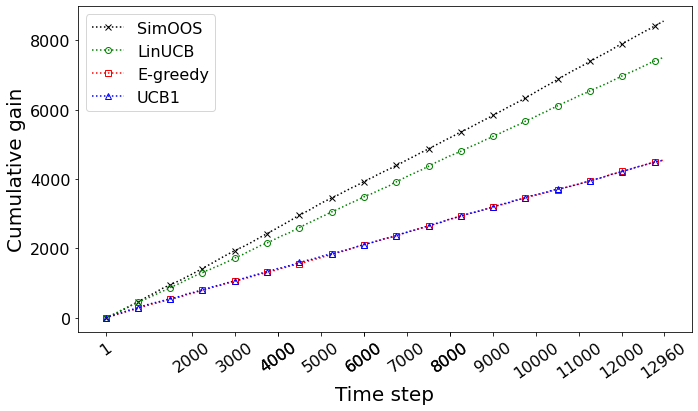

In [60]:
plot_gains({
    'E-greedy': gain_egreedy,
    'UCB1': gain_ucb,
    'LinUCB': gain_linucb,
    'SimOOS': gain_simoos,
},
)


In [61]:
best_eps # Epsilon-greedy

0.05

In [62]:
best_alpha_ucb # UCB1

0.05

In [63]:
best_alpha_linucb # LinUCB

0.1

In [64]:
best_delta_simoos # SimOOS

0.7